In [1]:
import os 
from Bio import SeqIO
import pickle
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import math

import pandas as pd

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [4]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 10
expName = "embedReads_setting1_3_to_8_kmers"

find_file_string = "_remb.csv.gz"
outPath = "Generated"
foldName_end = "folds.pickle"

modelNames = ["Dense_{}mer"]

epochs = 200
batch_size = 64
shuffle = False
seed = None

dataset_path = "CORENup-Datasets\\Datasets"
setting = "Setting1"

dataset_path = os.path.join(dataset_path[0:dataset_path.find('\\')]+"-Embeddings-Word2Vec", 
                                dataset_path[dataset_path.find('\\')+1:len(dataset_path)])


In [5]:
##################################################################################
##### define custom one hot encoding, contains code from repository
##################################################################################

def one_hot_encode(sequence):
    
    seq_encoded = np.zeros((len(sequence),4))
    dict_nuc = {
        "A": 0,
        "C": 1,
        "G": 2,
        "T":3
    }
    i = 0
    
    for single_character in sequence:
        if(single_character.upper() in dict_nuc.keys()):
            seq_encoded[i][dict_nuc[single_character.upper()]] = 1
            i = i+1
        else:
            return []
    
    return seq_encoded

In [6]:
##################################################################################
##### Function to generate the NN with dense FC layers only
##################################################################################

def DenseNN(input_shape=(64), learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None, 
            dense_decode_units = 64):
    
    beta = 0.001
    
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = input_shape))
    
    model.add(tf.keras.layers.Dense(dense_decode_units, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss, metrics = metrics) 
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)

    return model

In [7]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

In [8]:
##################################################################################
##### Generate list of files with similar string part
##################################################################################

file_list = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.find(find_file_string)>0:
            file_list.append((root, file))

In [9]:
file_list

[('CORENup-Datasets-Embeddings-Word2Vec\\Datasets\\Setting1\\Drosophila',
  'nucleosomes_vs_linkers_melanogaster_Drosophila_3_64_3_5_5_0.0001_10_1e-05_remb.csv.gz'),
 ('CORENup-Datasets-Embeddings-Word2Vec\\Datasets\\Setting1\\Drosophila',
  'nucleosomes_vs_linkers_melanogaster_Drosophila_5_64_3_5_5_0.0001_10_1e-05_remb.csv.gz'),
 ('CORENup-Datasets-Embeddings-Word2Vec\\Datasets\\Setting1\\Drosophila',
  'nucleosomes_vs_linkers_melanogaster_Drosophila_6_64_3_5_5_0.0001_10_1e-05_remb.csv.gz'),
 ('CORENup-Datasets-Embeddings-Word2Vec\\Datasets\\Setting1\\Drosophila',
  'nucleosomes_vs_linkers_melanogaster_Drosophila_7_64_3_5_5_0.0001_10_1e-05_remb.csv.gz'),
 ('CORENup-Datasets-Embeddings-Word2Vec\\Datasets\\Setting1\\Drosophila',
  'nucleosomes_vs_linkers_melanogaster_Drosophila_8_64_3_5_5_0.0001_10_1e-05_remb.csv.gz'),
 ('CORENup-Datasets-Embeddings-Word2Vec\\Datasets\\Setting1\\Elegans',
  'nucleosomes_vs_linkers_elegans_Elegans_3_64_3_5_5_0.0001_10_1e-05_remb.csv.gz'),
 ('CORENup-Data

In [10]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Kernel_Length" : [],
    "Dataset" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for file in file_list:
    
    current_dataset_variety = file[0].split("\\")[len(root.split("\\"))-1]
    k = file[1].split(".")[0].split("_")[-6]
    feature_length = file[1].split(".")[0].split("_")[-5]
    
    ##################################################################################
    ##### Read and divide data
    ##################################################################################
    
    read_df = pd.read_csv(os.path.join(file[0], file[1]), compression='gzip', header=0)
    
    nucleosomal_feature_list = read_df[read_df['Unnamed: 0'].str.contains("nucleosomal")].drop('Unnamed: 0',1).values.tolist()
    linker_feature_list = read_df[read_df['Unnamed: 0'].str.contains("linker")].drop('Unnamed: 0',1).values.tolist()
    
#     for i in range(0, len(nucleosomal_feature_list)):
#         nucleosomal_feature_list[i] = [[el] for el in nucleosomal_feature_list[i]] 
#     for i in range(0, len(linker_feature_list)):
#         linker_feature_list[i] = [[el] for el in linker_feature_list[i]] 
    
    print("\n======================================================================")
    print("\nFile:", os.path.join(file[0], file[1]))
    print("K-mer length:", k)
    print("Feature length:", feature_length)
    print("Nucleosomi:", str(len(nucleosomal_feature_list)))
    print("Linker:", str(len(linker_feature_list)))
    
    ##################################################################################
    ##### Generate Folds from dataset, and store to file
    ##################################################################################

    ## create the features and labels datasets for the training
    input_size = (len(read_df.columns)-1)
    labels = np.concatenate((np.ones((len(nucleosomal_feature_list), 1), dtype=np.float32), np.zeros((len(linker_feature_list), 1), dtype=np.float32)), axis=0)
    features = np.concatenate((nucleosomal_feature_list, linker_feature_list), 0)

    ## Write the k-fold dataset to file
    foldPath = os.path.join(outPath, expName, current_dataset_variety, "{}fold".format(n_fold))
    foldName = file[1] + foldName_end
    
    ##### ADDITIONAL CHANGES - USE PREVIOUS GENERATED FOLDS IF AVAILABLE

    if(os.path.isfile(os.path.join(foldPath, foldName))):
        folds = pickle.load(open(os.path.join(foldPath, foldName), "rb"))
    
    else:
        ## Generate the k-fold dataset
        folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
        
        if(not os.path.isdir(foldPath)):
            os.makedirs(foldPath)
        pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
    
    break
    
    ##################################################################################
    ##### TRAIN and PREDICT for every Fold, using both models (DLNN3 and DLNN5)
    ##################################################################################

    for modelName in modelNames:
        
        modelName = modelName.format(k)
        
        ## Create and set directory to save model
        modelPath = os.path.join(outPath, expName, current_dataset_variety, "{}fold".format(n_fold), "models", modelName)
        if(not os.path.isdir(modelPath)):
            os.makedirs(modelPath)
        
        ## fold counter
        i = 0
        
        for fold in folds:

            print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")

            ## Generate model using function
            model = Dense(input_shape = input_size)

            ## Define the model callbacks for early stopping and saving the model. Then train model
            modelCallbacks = [
                tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_bestModel-fold{}.hdf5".format(modelName, i)),
                                                   monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                   save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                 mode = 'auto', baseline = None, restore_best_weights = False)
            ]
            model.fit(x = fold["X_train"], y = fold["y_train"], batch_size = batch_size, epochs = epochs, verbose = 0, 
                      callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))

            ##################################################################################
            ##### Prediction and metrics for TRAIN dataset
            ##################################################################################

            y_pred = model.predict(fold["X_train"])
            label_pred = pred2label(y_pred)
            # Compute precision, recall, sensitivity, specifity, mcc
            acc = accuracy_score(fold["y_train"], label_pred)
            prec = precision_score(fold["y_train"],label_pred)

            conf = confusion_matrix(fold["y_train"], label_pred)
            if(conf[0][0]+conf[1][0]):
                sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
            else:
                sens = 0.0
            if(conf[1][1]+conf[0][1]):
                spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
            else:
                spec = 0.0
            if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
            else:
                mcc= 0.0
            fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
            auc = roc_auc_score(fold["y_train"], y_pred)

            evaluations["Model"].append(modelName)
            evaluations["Kernel_Length"].append("5,10")
            evaluations["Dataset"].append(current_dataset_variety)
            evaluations["Fold"].append(i)
            evaluations["Train_Test"].append("Train")
            evaluations["Accuracy"].append(acc)
            evaluations["Precision"].append(prec)
            evaluations["TPR"].append(tpr)
            evaluations["FPR"].append(fpr)
            evaluations["TPR_FPR_Thresholds"].append(thresholds)
            evaluations["AUC"].append(auc)
            evaluations["Sensitivity"].append(sens)
            evaluations["Specificity"].append(spec)
            evaluations["MCC"].append(mcc)

            ##################################################################################
            ##### Prediction and metrics for TEST dataset
            ##################################################################################

            y_pred = model.predict(fold["X_test"])
            label_pred = pred2label(y_pred)
            # Compute precision, recall, sensitivity, specifity, mcc
            acc = accuracy_score(fold["y_test"], label_pred)
            prec = precision_score(fold["y_test"],label_pred)

            conf = confusion_matrix(fold["y_test"], label_pred)
            if(conf[0][0]+conf[1][0]):
                sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
            else:
                sens = 0.0
            if(conf[1][1]+conf[0][1]):
                spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
            else:
                spec = 0.0
            if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
            else:
                mcc= 0.0
            fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
            auc = roc_auc_score(fold["y_test"], y_pred)

            evaluations["Model"].append(modelName)
            evaluations["Kernel_Length"].append("5,10")
            evaluations["Dataset"].append(current_dataset_variety)
            evaluations["Fold"].append(i)
            evaluations["Train_Test"].append("Test")
            evaluations["Accuracy"].append(acc)
            evaluations["Precision"].append(prec)
            evaluations["TPR"].append(tpr)
            evaluations["FPR"].append(fpr)
            evaluations["TPR_FPR_Thresholds"].append(thresholds)
            evaluations["AUC"].append(auc)
            evaluations["Sensitivity"].append(sens)
            evaluations["Specificity"].append(spec)
            evaluations["MCC"].append(mcc)

            i = i+1
            del model
            tf.keras.backend.clear_session()
        
#     ###############
#     ##### BREAK
#     ###############
    
#     break

##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0].format("all"))), "wb"))




File: CORENup-Datasets-Embeddings-Word2Vec\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster_Drosophila_3_64_3_5_5_0.0001_10_1e-05_remb.csv.gz
K-mer length: 3
Feature length: 64
Nucleosomi: 2900
Linker: 2850


In [15]:
folds[0]['X_train'][0].shape

(64,)

## Visualization of Evaluation

In [23]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd
import math


In [32]:
##################################################################################
##### Parameters used only in this section
##################################################################################

n_fold = 10
expName = "embedReads_setting1_3_to_8_kmers"
outPath = "Generated"

modelNames = ["Dense_{}mer"]

In [33]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0].format("all"))), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [34]:
np.unique(evaluations_df["Model"])

array(['Dense_3mer', 'Dense_5mer', 'Dense_6mer', 'Dense_7mer',
       'Dense_8mer'], dtype=object)

In [35]:
evalPath

'Generated\\embedReads_setting1_3_to_8_kmers\\_Evaluation_All_Datasets'

In [36]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset", 
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

DLNN_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(2), ['Train'])]
DLNN_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(2), ['Test'])]

In [37]:
DLNN_Train

Accuracy  Precision       AUC  \
Dataset      Model      Train_Test                                  
Drosophila   Dense_3mer Train       0.575420   0.579589  0.681518   
             Dense_5mer Train       0.698029   0.738293  0.742871   
             Dense_6mer Train       0.741990   0.771889  0.812406   
             Dense_7mer Train       0.781681   0.791135  0.838850   
             Dense_8mer Train       0.720000   0.735089  0.791287   
Elegans      Dense_3mer Train       0.525493   0.472991  0.792449   
             Dense_5mer Train       0.786710   0.779898  0.861762   
             Dense_6mer Train       0.797080   0.792294  0.870725   
             Dense_7mer Train       0.808073   0.779869  0.887356   
             Dense_8mer Train       0.815394   0.787321  0.877024   
Homo_Sapiens Dense_3mer Train       0.510216   0.545738  0.633360   
             Dense_5mer Train       0.713996   0.703275  0.778848   
             Dense_6mer Train       0.785480   0.775042  0.853561   
             Dense_7mer Train       0.801708   0.781105  0.863106   
             Dense_8mer Train       0.822363   0.785859  0.878833   
Yeast        Dense_3mer Train       0.534684   0.528578  0.938507   
             Dense_5mer Train       0.972038   0.969670  0.995883   
             Dense_6mer Train       0.964764   0.961391  0.993370   
             Dense_7mer Train       0.970994   0.970050  0.996259   
             Dense_8mer Train       0.988889   0.985289  0.998674   

                                    Sensitivity  Specificity       MCC  
Dataset      Model      Train_Test                                      
Drosophila   Dense_3mer Train          0.403436     0.579589  0.142501  
             Dense_5mer Train          0.671877     0.738293  0.403596  
             Dense_6mer Train          0.717691     0.771889  0.487198  
             Dense_7mer Train          0.772818     0.791135  0.563762  
             Dense_8mer Train          0.706520     0.735089  0.441015  
Elegans      Dense_3mer Train          0.517536     0.472991  0.075243  
             Dense_5mer Train          0.794163     0.779898  0.573801  
             Dense_6mer Train          0.802119     0.792294  0.594318  
             Dense_7mer Train          0.841671     0.779869  0.619201  
             Dense_8mer Train          0.848717     0.787321  0.633762  
Homo_Sapiens Dense_3mer Train          0.508102     0.545738  0.034893  
             Dense_5mer Train          0.726192     0.703275  0.428845  
             Dense_6mer Train          0.796837     0.775042  0.571510  
             Dense_7mer Train          0.825268     0.781105  0.605095  
             Dense_8mer Train          0.868772     0.785859  0.650020  
Yeast        Dense_3mer Train          0.400000     0.528578  0.058392  
             Dense_5mer Train          0.974650     0.969670  0.944010  
             Dense_6mer Train          0.968497     0.961391  0.929450  
             Dense_7mer Train          0.972030     0.970050  0.941904  
             Dense_8mer Train          0.992851     0.985289  0.977776

In [38]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ")
print(list(evaluations_df_grouped.columns))

Metrics Available : 
['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [75]:
metric_to_plot = "MCC"

In [57]:
a = list(np.unique(DLNN_Train.index.get_level_values(1)))
a

['Dense_3mer', 'Dense_5mer', 'Dense_6mer', 'Dense_7mer', 'Dense_8mer']

In [ ]:
DLNN_Train[DLNN_Train[]]

In [80]:
# Filter_df  = DLNN_Train[DLNN_Train.index.isin(a)]
DLNN_Train[DLNN_Train.index.get_level_values('Model').isin([a[0]])]

,,,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Dataset,Model,Train_Test,,,,,,
Drosophila,Dense_3mer,Train,0.575420,0.579589,0.681518,0.403436,0.579589,0.142501
Elegans,Dense_3mer,Train,0.525493,0.472991,0.792449,0.517536,0.472991,0.075243
Homo_Sapiens,Dense_3mer,Train,0.510216,0.545738,0.633360,0.508102,0.545738,0.034893
Yeast,Dense_3mer,Train,0.534684,0.528578,0.938507,0.400000,0.528578,0.058392


In [64]:
model_list = list(np.unique(DLNN_Train.index.get_level_values(1)))
model_list

['Dense_3mer', 'Dense_5mer', 'Dense_6mer', 'Dense_7mer', 'Dense_8mer']

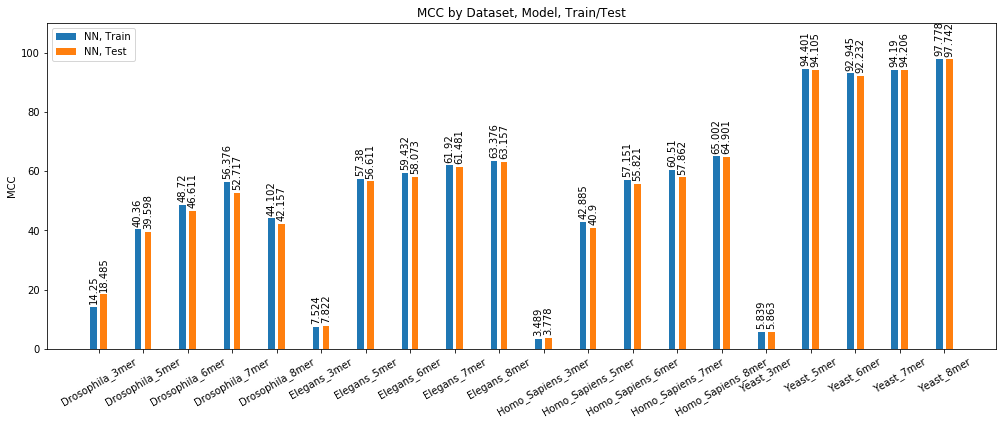

In [76]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(DLNN_Train[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(x - (1.5*(width/2)), round(DLNN_Train[metric_to_plot]*100, 3), width, label='NN, Train')
rects3 = ax.bar(x + (1.5*(width/2)), round(DLNN_Test[metric_to_plot]*100, 3), width, label='NN, Test')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
            max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
# ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
# ax.set_xticklabels([m+" - "+str(n) for m,n in 
#                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
#                   rotation=30)
ax.set_xticklabels([a + "_" + b.split("_")[1] for a, b in zip(DLNN_Train.index.get_level_values(0), DLNN_Train.index.get_level_values(1))],
                  rotation=30)


ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects3)

plt.show()

In [77]:
[max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
            max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)]

[0, 110]

In [85]:
list(DLNN_Train[DLNN_Train.index.get_level_values('Model').isin(["Dense_3mer"])].index.get_level_values('Dataset'))

['Drosophila', 'Elegans', 'Homo_Sapiens', 'Yeast']

ValueError: shape mismatch: objects cannot be broadcast to a single shape

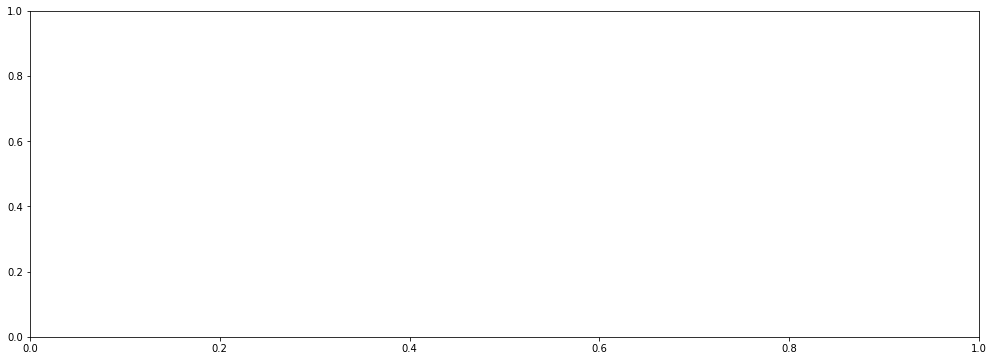

In [86]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(DLNN_Train[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))

rects0 = ax.bar(x - (5*(width/2)), round(DLNN_Train[DLNN_Train.index.get_level_values('Model').isin(["Dense_3mer"])][metric_to_plot]*100, 3), width, label='Dense_3mer, Train')
rects1 = ax.bar(x - (2.5*(width/2)), round(DLNN_Train[DLNN_Train.index.get_level_values('Model').isin(["Dense_5mer"])][metric_to_plot]*100, 3), width, label='Dense_5mer, Train')
rects2 = ax.bar(x, round(DLNN_Train[DLNN_Train.index.get_level_values('Model').isin(["Dense_6mer"])][metric_to_plot]*100, 3), width, label='Dense_6mer, Train')
rects3 = ax.bar(x + (2.5*(width/2)), round(DLNN_Train[DLNN_Train.index.get_level_values('Model').isin(["Dense_7mer"])][metric_to_plot]*100, 3), width, label='NN, Train')
rects4 = ax.bar(x + (5*(width/2)), round(DLNN_Train[DLNN_Train.index.get_level_values('Model').isin(["Dense_8mer"])][metric_to_plot]*100, 3), width, label='Dense_8mer, Train')

rects5 = ax.bar(x - (5*(width/2)), round(DLNN_Test[DLNN_Test.index.get_level_values('Model').isin(["Dense_3mer"])][metric_to_plot]*100, 3), width, label='Dense_3mer, Test')
rects6 = ax.bar(x - (2.5*(width/2)), round(DLNN_Test[DLNN_Test.index.get_level_values('Model').isin(["Dense_5mer"])][metric_to_plot]*100, 3), width, label='Dense_5mer, Test')
rects7 = ax.bar(x, round(DLNN_Test[DLNN_Test.index.get_level_values('Model').isin(["Dense_6mer"])][metric_to_plot]*100, 3), width, label='Dense_6mer, Test')
rects8 = ax.bar(x + (2.5*(width/2)), round(DLNN_Test[DLNN_Test.index.get_level_values('Model').isin(["Dense_7mer"])][metric_to_plot]*100, 3), width, label='NN, Test')
rects9 = ax.bar(x + (5*(width/2)), round(DLNN_Test[DLNN_Test.index.get_level_values('Model').isin(["Dense_8mer"])][metric_to_plot]*100, 3), width, label='Dense_8mer, Test')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
            max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
# ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
# ax.set_xticklabels([m+" - "+str(n) for m,n in 
#                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
#                   rotation=30)
ax.set_xticklabels(list(DLNN_Train[DLNN_Train.index.get_level_values('Model').isin(["Dense_3mer"])].index.get_level_values('Dataset')),
                  rotation=30)


ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)
autolabel(rects0)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)
autolabel(rects8)
autolabel(rects9)

plt.show()

### Store all metrics' plots to file

In [78]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    x = np.arange(len(DLNN_Train[metric_to_plot]))
    width = 0.15

    fig, ax = plt.subplots(figsize=(17,6))
    rects1 = ax.bar(x - (1.5*(width/2)), round(DLNN_Train[metric_to_plot]*100, 3), width, label='NN, Train')
    rects3 = ax.bar(x + (1.5*(width/2)), round(DLNN_Test[metric_to_plot]*100, 3), width, label='NN, Test')

    ## Custom y-axis tick labels
    ax.set_ylabel(metric_to_plot)
    ax.set_ylim([max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
            max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)])
    # ax.set_ylim([80, 105])

    ## Custom x-axis tick labels
    ax.set_xticks(x)
    # ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
    # ax.set_xticklabels([m+" - "+str(n) for m,n in 
    #                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
    #                   rotation=30)
    ax.set_xticklabels([a + "_" + b.split("_")[1] for a, b in zip(DLNN_Train.index.get_level_values(0), DLNN_Train.index.get_level_values(1))],
                      rotation=30)


    ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
    ax.legend(loc='upper left')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", 
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects3)
    
    plt.savefig(os.path.join(evalPath, "{}_{}_Comparison".format(metric_to_plot, modelNames[0].format("all"))))
    plt.close()
    